<a href="https://colab.research.google.com/github/CristinaMarsh/Reproduce/blob/main/2023/nbs/examples/PatchTST_A_Breakthrough_in_Time_Series_Forecasting_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Thanks: https://towardsdatascience.com/patchtst-a-breakthrough-in-time-series-forecasting-e02d48869ccc



## Channel-independence

Here, a multivariate time series is considered as a multi-channel signal. Each time series is basically a channel containing a signal.

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*UMypzsk6blXnyGPNi3VS9g.png)


In the figure above, we see how a multivariate time series is separated into individual series, and each is fed to the Transformer backbone as an input token. Then, predictions are made for each series and the results are concatenated for the final predictions.

Patching
Most work on Transformer-based forecasting models focused on building new mechanisms to simplify the original attention mechanism. However, they still relied on point-wise attention, which is not ideal when it comes to time series.

In time series forecasting, we want to extract relationships between past time steps and future time steps to make predictions. With point-wise attention, we are trying to retrieve information from a single time step, without looking at what surrounds that point. In other words, we isolate a time step, and do not look at points before or after.

This is like trying to understand the meaning of a word without looking at the words around it in a sentence.

Therefore, PatchTST makes use of patching to extract local semantic information in time series.

How patching works
Each input series is divided into patches, which are simply shorter series coming from the original one.

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*C_VbWh6Fl6ID3-Gcp71UEw.png)


Here, the patch can be overlapping or non-overlapping. The number of patches depends on the length of the patch P and the stride S. Here, the stride is like in convolution, it is simply how many timesteps separate the beginning of consecutive patches.

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*zbSnQQRx8Vk1KX8vG-q8Lg.jpeg)


Visualizing patching. Here, we have a sequence of 15 timesteps, with a patch length of 5 and a stride of 5 as well, resulting in three patches. Image by the author.


In the figure above, we can visualize the result of patching. Here, we have a sequence length (L) of 15 time steps, with a patch length (P) of 5 and a stride (S) of 5. The result is the series being separated into 3 patches.

Advantages of patching
With patching, the model can extract local semantic meaning by looking at groups of time steps, instead of looking at a single time step.

It also has the added benefit of greatly reducing the number of token being fed to the transformer encoder. Here, each patch becomes an input token to be input to the Transformer. That way, we can reduce the number of token from L to approximately L/S.

That way, we greatly reduce the space and time complexity of the model. This in turn means that we can feed the model a longer input sequence to extract meaningful temporal relationships.

Therefore, with patching, the model is faster, lighter, and can treat a longer input sequence, meaning that it can potentially learn more about the series and make better forecasts.

Transformer encoder
Once the series is patched, it is then fed to the transformer encoder. This is the classical transformer architecture. Nothing was modified.

Then, the output is fed to linear layer, and predictions are made.

Improving PatchTST with representation learning
The authors of the paper suggested another improvement to the model by using representation learning.




In [3]:
! pip install neuralforecast datasetsforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.1/160.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.4/722.4 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.6/273.6 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.6/154.6 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.8/283.8 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 19.0 MB/s 

In [4]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS, NBEATS, PatchTST

from neuralforecast.losses.pytorch import MAE
from neuralforecast.losses.numpy import mae, mse

from datasetsforecast.long_horizon import LongHorizon

In [5]:
Y_df, X_df, S_df = LongHorizon.load(directory="./data", group="Exchange")

100%|██████████| 314M/314M [00:09<00:00, 32.7MiB/s]


In [6]:
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

Y_df.head()

,unique_id,ds,y
0,0,1990-01-01,0.606785
1,0,1990-01-02,0.570900
2,0,1990-01-03,0.618423
3,0,1990-01-04,0.611634
4,0,1990-01-05,0.600966


In [12]:
Y_df['unique_id'].value_counts()[0]

7588

In [15]:
n_time = Y_df['unique_id'].value_counts()[0]

In [16]:
val_size = 760
test_size = 1517

print(n_time, val_size, test_size)

7588 760 1517


In [17]:
u_id = '0'

x_plot = pd.to_datetime(Y_df[Y_df.unique_id==u_id].ds)
y_plot = Y_df[Y_df.unique_id==u_id].y.values

In [18]:
x_plot

0      1990-01-01
1      1990-01-02
2      1990-01-03
3      1990-01-04
4      1990-01-05
          ...    
7583   2010-10-06
7584   2010-10-07
7585   2010-10-08
7586   2010-10-09
7587   2010-10-10
Name: ds, Length: 7588, dtype: datetime64[ns]

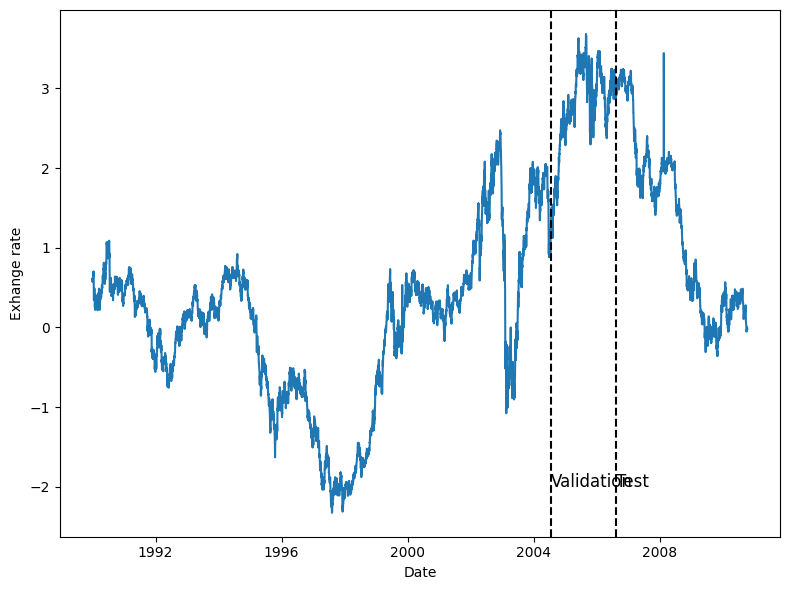

In [20]:
x_val = x_plot[n_time - val_size - test_size]
x_test = x_plot[n_time - test_size]

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x_plot, y_plot)
ax.set_xlabel('Date')
ax.set_ylabel('Exhange rate')
ax.axvline(x_val, color='black', linestyle='--')
ax.axvline(x_test, color='black', linestyle='--')

plt.text(x_val, -2, 'Validation', fontsize=12)
plt.text(x_test,-2, 'Test', fontsize=12)

plt.tight_layout()

In [21]:
horizon = 96

models = [NHITS(h=horizon,
               input_size=2*horizon,
               max_steps=50),
         NBEATS(h=horizon,
               input_size=2*horizon,
               max_steps=50),
         PatchTST(h=horizon,
                 input_size=2*horizon,
                 max_steps=50)]

INFO:lightning_fabric.utilities.seed:Global seed set to 1
INFO:lightning_fabric.utilities.seed:Global seed set to 1
INFO:lightning_fabric.utilities.seed:Global seed set to 1


In [22]:
nf = NeuralForecast(models=models, freq='D')

In [23]:
preds_df = nf.cross_validation(df=Y_df, val_size=val_size, test_size=test_size, n_windows=None)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [27]:
y_true = preds_df['y'].values
y_pred_nhits = preds_df['NHITS'].values
y_pred_nbeats = preds_df['NBEATS'].values
y_pred_patchtst = preds_df['PatchTST'].values




In [ ]:
unique_id_select = preds_df.unique_id.unique().tolist()

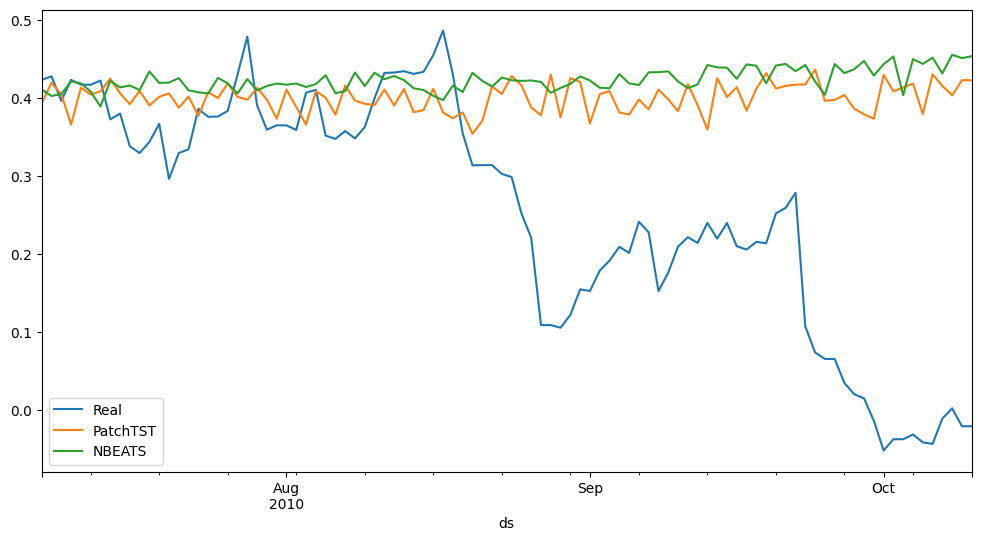

In [53]:
fig, ax = plt.subplots(figsize=(12,6))
preds_df[preds_df['unique_id']==unique_id_select[0]].iloc[-horizon:].set_index('ds')['y'].plot(label='Real')
preds_df[preds_df['unique_id']==unique_id_select[0]].iloc[-horizon:].set_index('ds')['PatchTST'].plot(label='PatchTST')
preds_df[preds_df['unique_id']==unique_id_select[0]].iloc[-horizon:].set_index('ds')['NBEATS'].plot(label='NBEATS')
plt.legend()

In [ ]:
n_series = len(Y_df['unique_id'].unique())

y_true = y_true.reshape(n_series, -1, horizon)
y_pred_nhits = y_pred_nhits.reshape(n_series, -1, horizon)
y_pred_nbeats = y_pred_nbeats.reshape(n_series, -1, horizon)
y_pred_patchtst = y_pred_patchtst.reshape(n_series, -1, horizon)

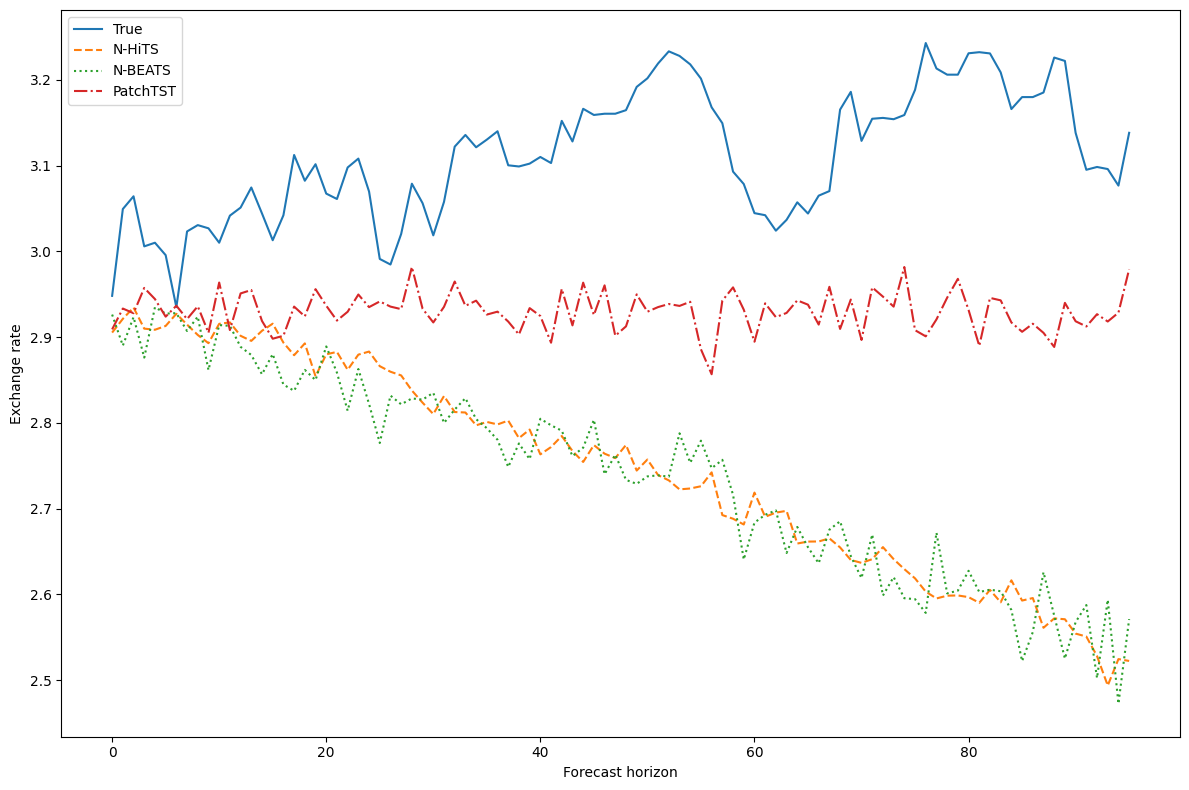

In [25]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(y_true[0, 0, :], label='True')
ax.plot(y_pred_nhits[0, 0, :], label='N-HiTS', ls='--')
ax.plot(y_pred_nbeats[0, 0, :], label='N-BEATS', ls=':')
ax.plot(y_pred_patchtst[0, 0, :], label='PatchTST', ls='-.')
ax.set_ylabel('Exchange rate')
ax.set_xlabel('Forecast horizon')
ax.legend(loc='best')

plt.tight_layout()

In [26]:
data = {'N-HiTS': [mae(y_pred_nhits, y_true), mse(y_pred_nhits, y_true)],
       'N-BEATS': [mae(y_pred_nbeats, y_true), mse(y_pred_nbeats, y_true)],
       'PatchTST': [mae(y_pred_patchtst, y_true), mse(y_pred_patchtst, y_true)]}

metrics_df = pd.DataFrame(data=data)
metrics_df.index = ['mae', 'mse']

metrics_df.style.highlight_min(color='lightgreen', axis=1)

,N-HiTS,N-BEATS,PatchTST
mae,0.203310,0.203300,0.198059
mse,0.082161,0.081599,0.081635
